In [1]:
# Importing libraries and library functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

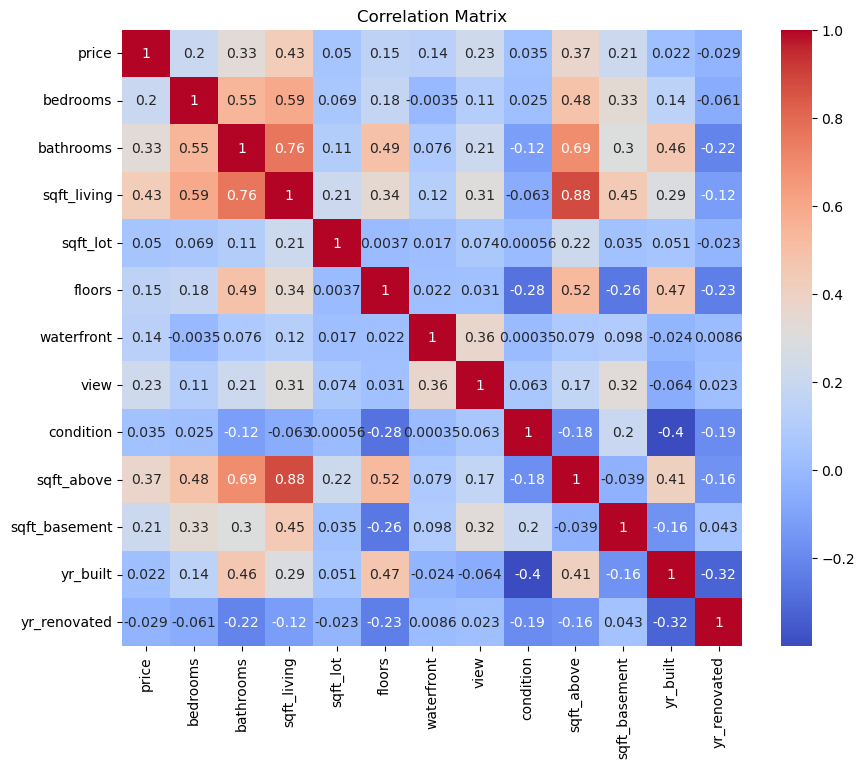

In [2]:
# Load the dataset
data_path = 'data.csv'  
data = pd.read_csv(data_path)

# check
print(data.info())

# Handle missing values
df = data
df.dropna(inplace=True) 

# Display the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Define features 
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors']
X = df[features]
y = df['price']

Mean Squared Error: 1070789490713.07
R-squared: -0.05


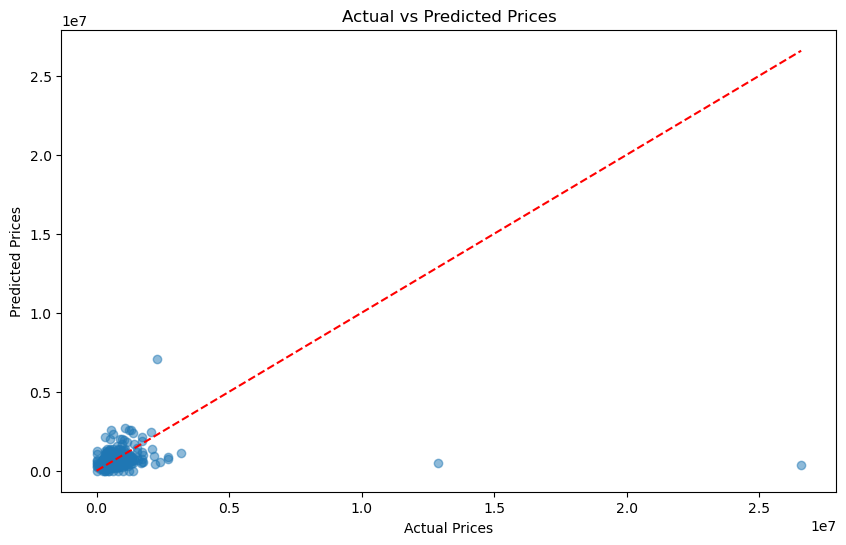

Cross-Validation Scores: [-7.27778228 -2.6729885  -1.075753   -5.98882237 -0.05560129]
Mean CV Score: -3.41


In [3]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Select the "informative" feature
feature_importances = model.feature_importances_
features_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)
selected_feature = features_importance_df.iloc[0]['Feature']  # Selected "informative" feature

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r_squared:.2f}')

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

# Cross-Validation
cv_scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')

In [4]:
# improvements: 
# ignore unnecessary columns 
# removing outliers 
# l1 and l2 regularization 
# gradient boosted decosopm tree 

In [5]:
# Drop unnecessary columns
df = df.drop(['date', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_renovated', 'street', 'city', 'country'], axis=1)
df['statezip'] = df['statezip'].apply(lambda x: int(x.split(' ')[1]))


Feature Importances:
       Feature  Importance
2  sqft_living    0.767638
1    bathrooms    0.112073
0     bedrooms    0.060899
3       floors    0.059390
Mean Squared Error: 1070789490713.07
R-squared: -0.05%


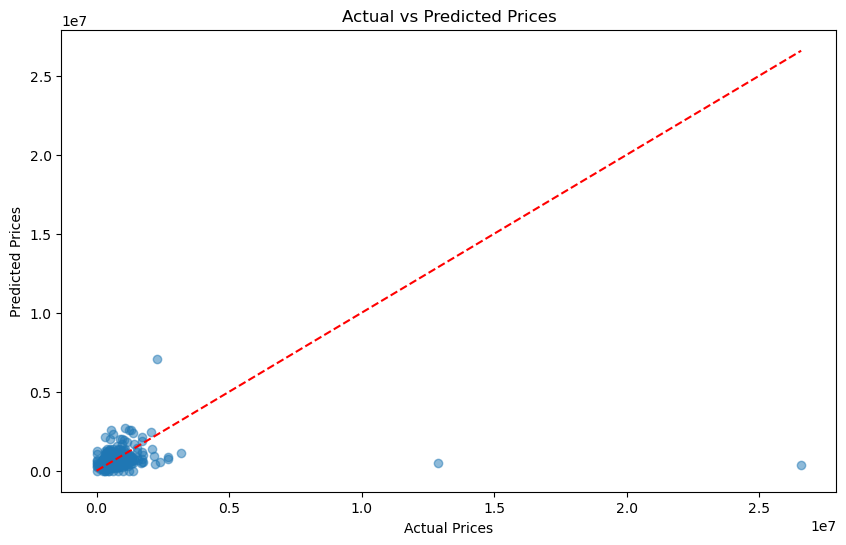

Cross-Validation Scores: [-7.27778228 -2.6729885  -1.075753   -5.98882237 -0.05560129]
Mean CV Score: -3.41


In [11]:
# Define features 
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors']
X = df[features]
y = df['price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Select the "informative" feature
feature_importances = model.feature_importances_
features_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)
selected_feature = features_importance_df.iloc[0]['Feature']  # Selected "informative" feature

print("\nFeature Importances:")
print(features_importance_df)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R-squared: {r_squared:.2f}%')

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

# Cross-Validation
cv_scores = cross_val_score(model, X, y, cv=5)
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Score: {np.mean(cv_scores):.2f}')